In [1]:
import numpy as np

from weight import *
from utils import save, load
from library import *
from process_library_terms import *

In [2]:
%%prun # profiling

### load data
# vicsek:
#arrays.npy - normal. arrays2.npy - very few particles. arrays3.npy - high density. arrays4.npy - high density, low noise.
#arrays5.npy - small domain, one clump
#datasets = ['arrays.npy', 'arrays2.npy', 'arrays3.npy']#, 'arrays5.npy']
#datasets = ['data_bu.npy'] # burgers' equation data
## it may be interesting to reintroduce regression on multiple datasets,
## but for now we're just not going to do it

dataset = 'data_bu.npy' 
#for i, dset in enumerate(datasets):
positions, vs, deltat, dims = load(dataset, 4)
world_size = np.array([dims[0], dims[0], dims[1]])
#world_size[2] = 50 # restrict to first 50 time steps
data_dict = {}
data_dict['v'] = vs
v_obs = Observable('v', 1)
observables = [v_obs]

# fix random seed
np.random.seed(1)

# initial setup of dataset
srd = SRDataset(world_size, data_dict, positions, observables, 
                kernel_sigma=0.6, cg_res=4, deltat=deltat, cutoff=8)
#kernel_sigma=1 or smaller

# initialize libraries, domains, and weights
srd.make_libraries(max_complexity=4, max_observables=3)
dom_width = 10 #80
dom_time = 20
srd.make_domains(ndomains=50, domain_size=[dom_width, dom_width, dom_time], pad=0)
#srd.make_domains(ndomains=1, domain_size=[dom_width, dom_width, dom_time], pad=0)
srd.make_weights(m=6, qmax=0)
srd.make_library_matrices()

save('Q_bu.npy', srd.dxs, srd.libs)

         35911395 function calls (34571871 primitive calls) in 108.080 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      500   23.653    0.047   99.656    0.199 process_library_terms.py:186(eval_cgp)
   725160   19.956    0.000   49.072    0.000 convolution.py:15(gauss1d)
  1488859    8.806    0.000    8.806    0.000 {method 'reduce' of 'numpy.ufunc' objects}
   754717    5.793    0.000    5.793    0.000 {built-in method numpy.array}
   725160    5.757    0.000    5.757    0.000 {method 'outer' of 'numpy.ufunc' objects}
   732319    5.200    0.000    5.200    0.000 {built-in method builtins.sum}
  1463501    4.425    0.000   15.680    0.000 fromnumeric.py:69(_wrapreduction)
   725160    3.554    0.000    8.720    0.000 shape_base.py:512(expand_dims)
   737760    2.858    0.000    2.858    0.000 {built-in method numpy.arange}
2269480/2217623    2.854    0.000   32.115    0.000 {built-in method numpy.core._multiarray_umat

[rho, rho[v], rho[v * v], rho[v * v * v]]
IntegrationDomain([203, 133, 79], [242, 172, 98])



Bad key "text.kerning_factor" on line 4 in
C:\Users\nerpa\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


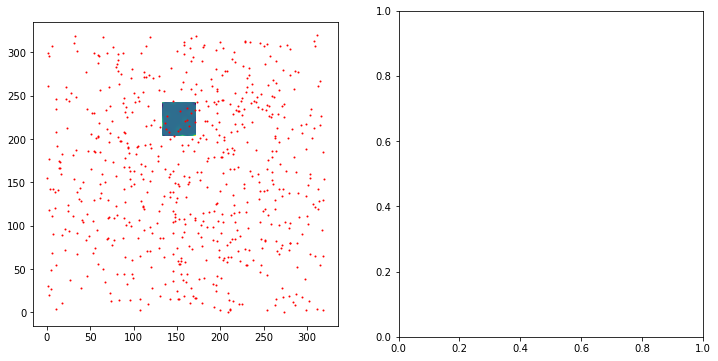

In [3]:
import matplotlib.pyplot as plt

fig, (ax1, ax2)= plt.subplots(ncols=2, figsize=(12,6))
print(srd.cgps)
print(srd.domains[2])
cg_arr = srd.cg_dict[srd.cgps[1], (0,), srd.domains[2]]
ax1.imshow(cg_arr[:, :, 0], origin='lower', extent=[133, 172, 203, 242])
ax1.scatter(srd.scaled_pts[:, 1, 79].flatten(), srd.scaled_pts[:, 0, 79].flatten(), s=1, c='red')


In [4]:
_, libs = load('Q_bu.npy', 2)
libs = libs.item()

In [8]:
from identify_models import *
opts = dict()
opts['threshold'] = "'threshold'"
opts['row_norms'] = libs[0].row_weights
opts['gamma'] = 2
opts['verbose'] = False
opts['delta'] = 1e-8 # apparently this reaches machine precision as the relative error
opts['char_sizes'] = libs[0].col_weights
opts1 = opts.copy()
opts1['char_sizes'] = libs[1].col_weights
opts1['row_norms'] = libs[1].row_weights

#eqs0, lambdas0, derived_eqs0, excluded_terms = identify_equations(Q0, opts, terms0, observables, threshold=1e-5, 
#                       max_complexity=None, max_equations=999, timed=True)
#print(excluded_terms)
#eqs1, lambdas1, derived_eqs1, excluded_terms = identify_equations(Q1, opts1, terms1, observables, threshold=1e-5, 
#                       max_complexity=None, max_equations=999, timed=True, excluded_terms=excluded_terms)
#print(excluded_terms)
eqs, lambdas, derived_eqs, excluded_terms = interleave_identify([libs[0].Q, libs[1].Q], 
[opts, opts1], [libs[0].terms, libs[1].terms], threshold=1e-4)

#[Term 10] 1.0 * dt rho[v_i]. (Char. size: 0.11975507211624986)
#[Term 16] 0.99735777073552 * dj rho[v_i * v_j]. (Char. size: 0.0015462422401189982)
#Model residual: 1.3999255788487568e-05

[0.00 s]
Identified model: 0.9988353493478821 * dj rho[v_j] + 1.0 * dt rho = 0 (order 3, residual 4.71e-05)


In [11]:
## mostly not planning to use this code

from ipynb.fs.full.sparse_reg import *
opts = dict()
opts['threshold'] = "'pareto'"
#opts['verbose'] = True
#opts['brute_force'] = False
#opts['threshold'] = "'threshold'"
#opts['n_terms'] = len(terms0)
#opts['gamma'] = 1.2
opts['char_sizes'] = srd.libs[0].col_weights
Xi, lambd, best_term, lambda1 = sparse_reg(srd.libs[0].Q, opts=opts)
print(srd.libs[0].Q.shape)

(50, 21)


In [8]:
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {srd.libs[0].terms[i]}")
print("Model residual:", lambd)
print("One-term model residual:", lambda1)
print(f"Best term (#{best_term}):", srd.libs[0].terms[best_term])

[Term 19] 1.0 * rho[v_j] * rho[v_j]
Model residual: 0.0030944418121483697
One-term model residual: 1.294046607514735e-05
Best term (#6): dt^3 rho


In [ ]:
opts['verbose'] = True
opts['char_sizes'] = srd.libs[1].col_weights
opts['avoid'] = []
opts['row_norms'] = None
Xi, lambd, best_term, lambda1 = sparse_reg(srd.libs[1].Q, opts=opts)
print(srd.libs[1].Q.shape)

In [ ]:
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {srd.libs[1].terms[i]}")
print("Model residual:", lambd)
print("One-term model residual:", lambda1)
print("Best term:", srd.libs[1].terms[best_term])

In [ ]:
### not fixed
for term, size in zip(terms1, char_sizes1):
    print(term, size)

NameError: name 'terms0' is not defined

In [7]:
continuity_terms = ['dt rho', 'dj rho[v_j]']
#continuity_terms = ['dt rho * rho', 'rho * rho * dj v_j', 'dj rho * rho * v_j']
#continuity_terms = ['dt rho', 'dj rv_j']
col_numbers = [find_term(srd.libs[0].terms, name) for name in continuity_terms]
Xi, lambd = regress(srd.libs[0].Q, col_numbers)
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {srd.libs[0].terms[i]}.")# (Char. size: {srd.libs[0].col_weights[i]})")
print("Model residual:", lambd)

[Term 3] 1.0 * dt rho.
[Term 14] 0.9972914312460868 * dj rho[v_j].
Model residual: 1.2526695928922025e-05


In [6]:
burger_terms = ['dt rho[v_i]', 'dj rho[v_i * v_j]']
#burger_terms = ['rho * dt rv_i', 'dj rv_i * rv_j']
col_numbers = [find_term(srd.libs[1].terms, name) for name in burger_terms]
Xi, lambd = regress(srd.libs[1].Q, col_numbers)
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {srd.libs[1].terms[i]}. (Char. size: {srd.libs[1].col_weights[i]})")
print("Model residual:", lambd)

[Term 10] 1.0 * dt rho[v_i]. (Char. size: 0.1662800448030401)
[Term 16] 0.99892944272455 * dj rho[v_i * v_j]. (Char. size: 0.004514085450835974)
Model residual: 0.00019179545994085456


In [14]:
### not fixed (obviously)
#veqconst_terms = ['1', 'v_j * v_j']
veqconst_terms = ['rho', 'rho * v_j * v_j']
col_numbers = [find_term(terms0, name) for name in veqconst_terms]
Xi, lambd = regress(Q0, col_numbers)
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {terms0[i]}. (Char. size: {char_sizes0[i]})")
print("Model residual:", lambd)

[Term 16] -0.004286563115825593 * rho. (Char. size: 0.1464261231728444)
[Term 28] 1.0 * rho * v_j * v_j. (Char. size: 0.0005121399208783936)
Model residual: 0.0005697337514007149


In [ ]:
rho dt^2 v = 10^-4 dt rho * grad rho